In [1]:
import pandas as pd
from utils.text import plot_wordclouds
import seaborn as sns

In [2]:
binary=False

# Carregando dados de análise

In [3]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [5]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [6]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


In [7]:
# Para focar a análise em apenas duas classes: positivo e negativo
if binary:
    data_df = data_df[data_df["label"] != "neutro"]

# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: conversão para lower-case, remoção de stop-words, remoção de hashtags e lemmatização. Feito o processamento, o documento é convertido para uma representação densa utilizando *word embeddings*. O spaCy utiliza embeddings FastText de 300 dimensões para representar seus tokens. Assim, textos serão representados por 300 dimensões, que correspondem a média das *word embeddings* dos seus tokens. 

- Obs: Tokens que não estão no vocabulário das embeddings pre-treinadas são representadas como vetores de zeros.

In [8]:
import spacy
import numpy as np
nlp = spacy.load("pt_core_news_md")

In [9]:
t = nlp("qdhiuweui frase de teste")

In [10]:
# teste para palavras que não estão no vocabulário
t[0].vector 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [11]:
from typing import Iterable

def convert_text_to_vector(text: str) -> Iterable[str]:

    tokens = nlp(text)

    text_vector = np.zeros(300)
    used_tokens = 0

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remoção de stop-words
        if token.is_punct: continue             # remoção de pontuação
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"
        if "@" in lemma: continue               # remoção simples de hashtags

        text_vector += token.vector
        used_tokens += 1
    
    return text_vector / used_tokens

# Conversão dos textos para representações densas

In [12]:
from sklearn.preprocessing import normalize

In [13]:
# Conversão para representações densas
text_vectors = [convert_text_to_vector(text) for text in data_df["text"]]

In [14]:
# Normalização L2 para geração de vetores unitários
text_vectors = normalize(text_vectors)

In [15]:
text_vectors.shape

(2463, 300)

# Agrupamento usando K-means

In [16]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [17]:
# Quantidades de clusters para avaliar
n_clusters = list(range(2,11))
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [18]:
fitted_models = []
for k in tqdm(n_clusters):
    
    kmeans = KMeans(n_clusters=k, n_init=100, init='random', max_iter=500)
    kmeans.fit(text_vectors)

    fitted_models.append(kmeans)

100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


# Avaliando silhueta dos agrupamentos gerados

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster.silhouette import silhouette_visualizer
import numpy as np
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

In [21]:
sns.set(rc={'figure.figsize':(15,6)})

In [22]:
silhouettes = [silhouette_score(text_vectors, kmeans.labels_) for kmeans in fitted_models]
inertias = [kmeans.inertia_ for kmeans in fitted_models]

Text(0.5, 0, 'Number of clusters')

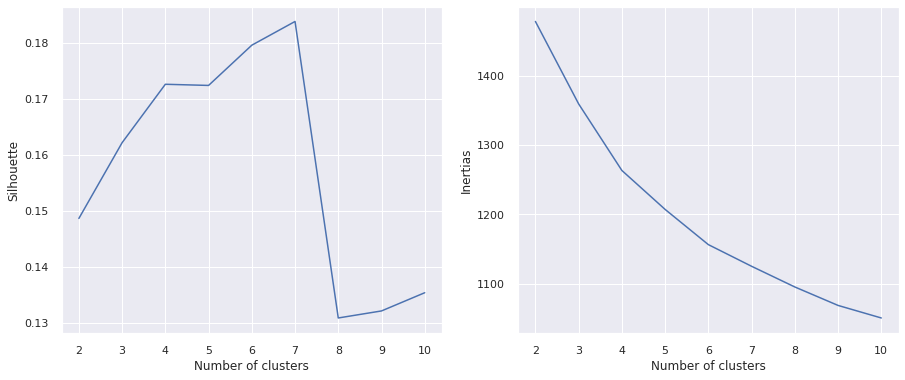

In [23]:
fig, axes = plt.subplots(1,2)

ax = sns.lineplot(x=n_clusters, y=silhouettes, ax=axes[0])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Number of clusters")

ax = sns.lineplot(x=n_clusters, y=inertias, ax=axes[1])
ax.set_ylabel("Inertias")
ax.set_xlabel("Number of clusters")

In [24]:
# Escolhendo o modelo de maior silhueta mpedia para análise
kmeans = fitted_models[np.argmax(silhouettes)]

In [25]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)
data_df["cluster"] = kmeans.labels_

In [26]:
mean_silh = data_df["silhouette"].mean()

In [27]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 1124.8819653500348
- Mean silhouette: 0.18383014072250506


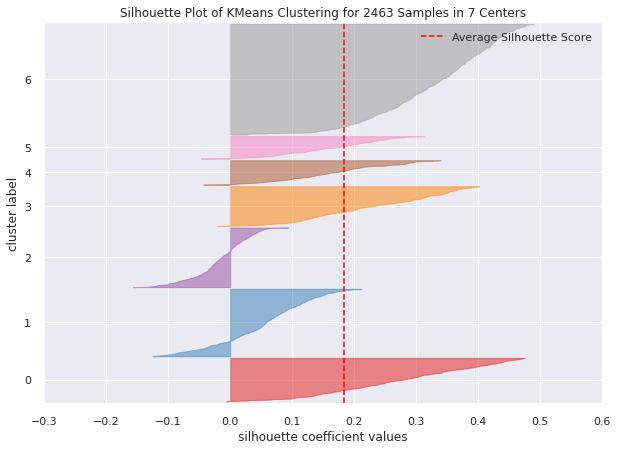

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9db5b638d0>,
                     estimator=KMeans(init='random', max_iter=500, n_clusters=7,
                                      n_init=100))

In [28]:
sns.set(rc={'figure.figsize':(10,7)})
silhouette_visualizer(
    kmeans,
    X=text_vectors,
    y=data_df["label"].values,
    is_fitted=True
)

# Comparação entre clusters

Comparando pares de clusters, com relação as classes (positivo, neutro ou negativo) e palavras frequentes.

In [29]:
cluster_pair = (0, 6)

In [30]:
c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

# Distribuição de classes por cluster

In [31]:
order = ["positivo", "negativo"] if binary else \
        ["positivo", "neutro", "negativo"]

Text(0.5, 0, 'Cluster 6')

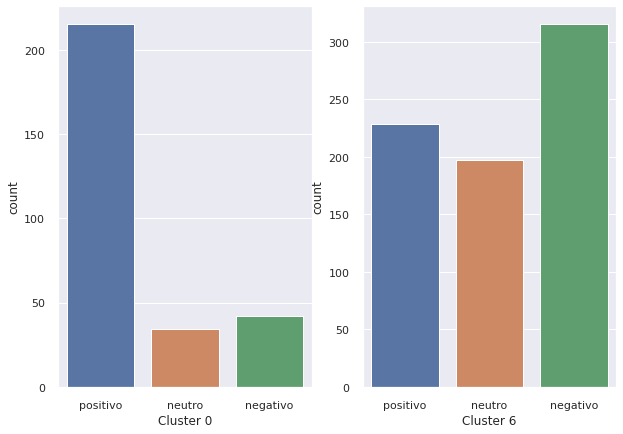

In [32]:
fig, axes = plt.subplots(1,2)

sns.countplot(data=c0_df, x="label", ax=axes[0], order=order)
axes[0].set_xlabel(f"Cluster {cluster_pair[0]}")
sns.countplot(data=c1_df, x="label", ax=axes[1], order=order)
axes[1].set_xlabel(f"Cluster {cluster_pair[1]}")

## Wordclouds por cluster

Gerando nuvens de palavras para cluster do par em análise.

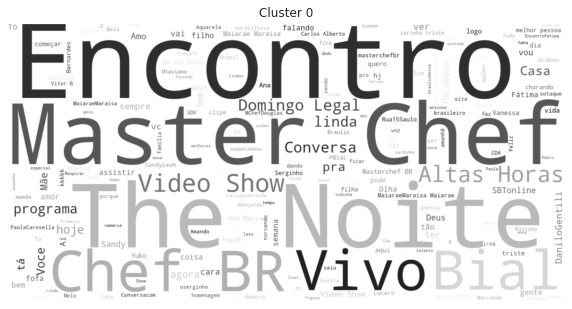

In [33]:
plot_wordclouds(
    text=" ".join(c0_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[0]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

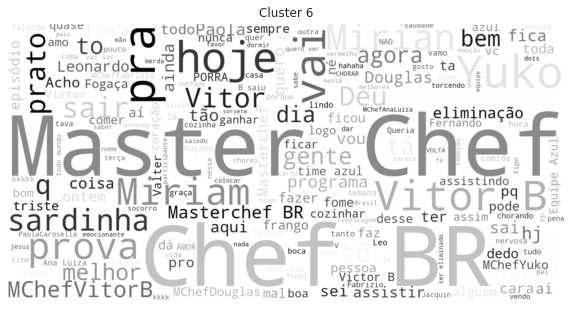

In [34]:
plot_wordclouds(
    text=" ".join(c1_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[1]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

# Visualizando exemplos de maior silhueta por cluster

In [35]:
cluster = 2

In [36]:
c_df = data_df[data_df["cluster"] == cluster]

In [37]:
pd.set_option('max_colwidth', None)
c_df.sort_values(by="silhouette", ascending=False).head(10)

,label,text,silhouette,cluster
8980,positivo,Cora representando os Taurinos Encontro,0.094081,2
2475,neutro,Quem é esse Bailarino disfarçado de @TiagoLeifert no Encontro?,0.078878,2
7625,negativo,"É muito triste sabe que viagens,acampamentos é uma realidade muito mas muito distante de da população do br. Encontro",0.075239,2
218,positivo,Admiro essas mulheres que fazem parto natural. Altas Horas,0.065684,2
391,neutro,Casas pernambucanas ainda sobrevive. Encontro,0.063591,2
2318,neutro,Tem uma menina parecida com a Vitória do Anavitória no Altas Horas hsjshshs Altas Horas,0.060811,2
2365,neutro,"Caralho, anos! Encontro",0.060605,2
2065,positivo,Vamos ver a cantora que atravessa gerações... sandy no encontro Encontro,0.059518,2
4730,positivo,Encontro adorei a participação da Fátima no Videoshowaovivo,0.058875,2
1835,positivo,Que culto maravilhoso ontem Jeruel Queria muito ir no Encontro no final de semana se no pré Encontro foi espetacular imgina lá no sítio.,0.055662,2


# Análise PCA

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [39]:
scaler = StandardScaler()
std_vectors = scaler.fit_transform(text_vectors)

In [40]:
pca = PCA(n_components=2)
pca_representations = pca.fit_transform(std_vectors)

In [41]:
print(f"Usar 2 componentes principais preserva {pca.explained_variance_ratio_.sum() * 100}% da variância dos dados.")

Usar 2 componentes principais preserva 24.51848490836958% da variância dos dados.


## Visualizando as representações em duas dimensões

A partir das representações geradas pelas médias das embeddings FastText, utilizamos PCA para extrair 2 componentes principais para plot 2D. Em seguida, as imagens abaixo mostram como os clusters e as classes (positivo, neutro e nagtivo) estão distribuídas utilizando 2 componentes.

Text(0.5, 1.0, 'Labels')

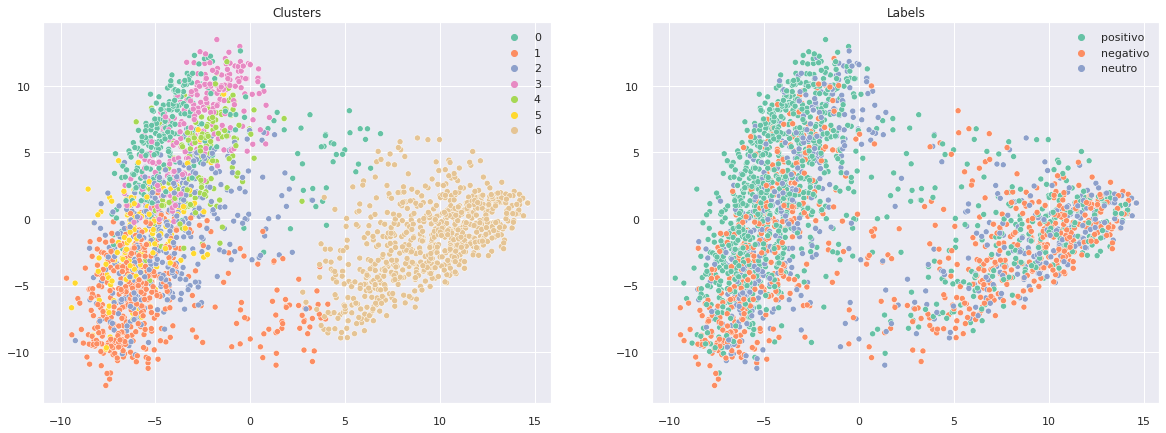

In [42]:
sns.set(rc={'figure.figsize':(20,7)})

fig, axes = plt.subplots(1,2)

sns.scatterplot(x=pca_representations[:, 0], y=pca_representations[:, 1], hue=data_df["cluster"].values, palette="Set2", ax=axes[0])
axes[0].set_title("Clusters")

sns.scatterplot(x=pca_representations[:, 0], y=pca_representations[:, 1], hue=data_df["label"].values, palette="Set2", ax=axes[1])
axes[1].set_title("Labels")